In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [36]:
pip install xgboost

In [38]:
pip install imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import re

# modèles et métriques
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# sur- et sous-échantillonage
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter


from sklearn.model_selection import cross_val_score

# import des données
import joblib

from sklearn.neighbors import NearestNeighbors

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


# Jeu de données

In [144]:
mlflow.autolog()

2023/02/17 11:07:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/02/17 11:07:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/02/17 11:07:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/02/17 11:07:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/02/17 11:07:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/02/17 11:07:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
application_train = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\application_train.csv", low_memory=False)
application_test = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\application_test.csv", low_memory=False)
bureau_ = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\bureau.csv", low_memory=False)
bureau_balance = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\bureau_balance.csv", low_memory=False)
credit_card_balance = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\credit_card_balance.csv", low_memory=False)
previous_application = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\previous_application.csv", low_memory=False)
sample_submission = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\sample_submission.csv", low_memory=False)
cash_balance = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\POS_CASH_balance.csv", low_memory=False)
intallation_paiement = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\installments_payments.csv", low_memory=False)

In [4]:
credit_card_balance2 = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\credit_card_balance.csv", low_memory=False, dtype='category')


In [5]:
description_colonne_homecredit = pd.read_csv(r"C:\Users\ruiz-\OneDrive\Bureau\testdoc.csv", low_memory=False)

In [61]:
description_colonne_homecredit.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,"2,application_{train|test}.csv,TARGET,""Target ...",NaN,NaN,NaN,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


#  Les fonctions a utiliser

In [6]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = application_train
    test_df = application_test
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = bureau_
    bb = bureau_balance
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = previous_application
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = cash_balance
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = intallation_paiement
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = credit_card_balance2
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 13s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 26)
Process installments payments - done in 20s


ValueError: no results

# Analyse des tables

In [17]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [7]:
import missingno as msno

In [12]:
def description_dataset(data, matrix):
    if matrix == True:
        msno.matrix(data)
    print(f'Types :{data.dtypes}')
    print("--" * 30)
    print(data.describe())
    print("--" * 30)
    print("Valeurs manquantes par colonnes ( % ): ")
    print((((data.isna().sum() / data.shape[0]) * 100).round(2)).sort_values(ascending= False))

## application_train

In [11]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Types :SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object
------------------------------------------------------------
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000     

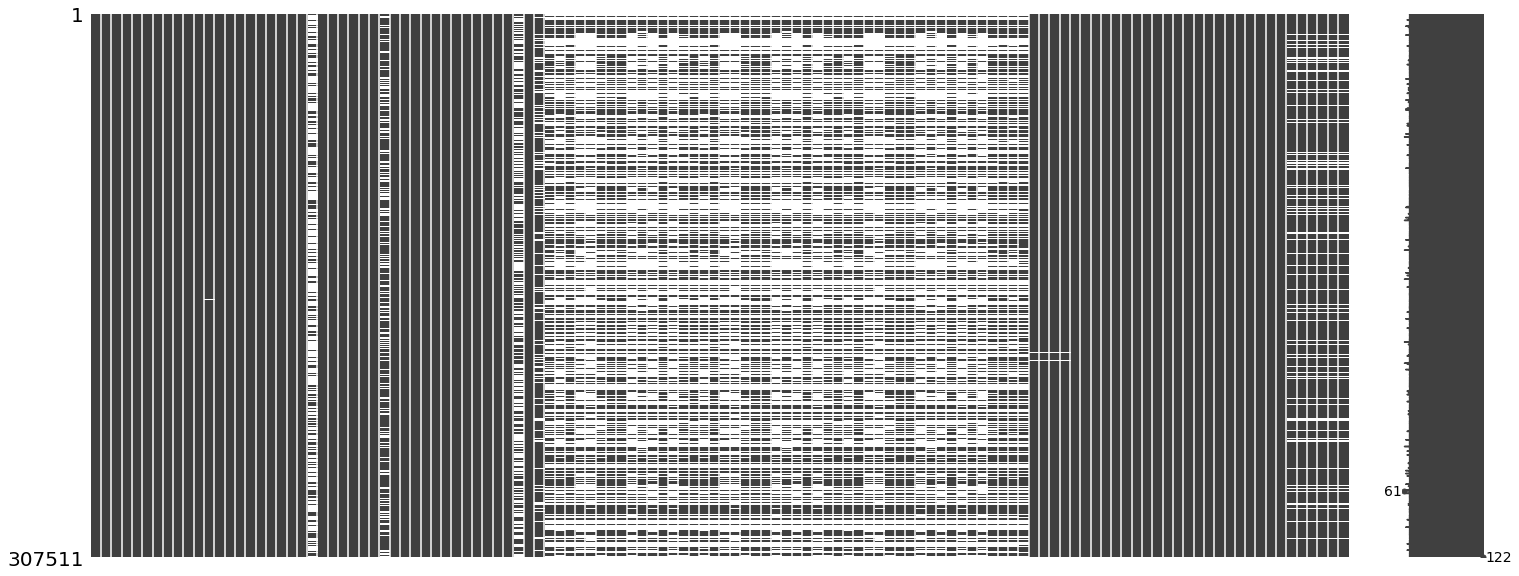

In [19]:
description_dataset(application_train, matrix= True)

## application_test

Types :SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object
------------------------------------------------------------
          SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04   
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   
std    103169.547296      0.709047      1.015226e+05  3.653970e+05   
min    100001.000000      0.000000      2.694150e+04  4.500000e+04   
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05 

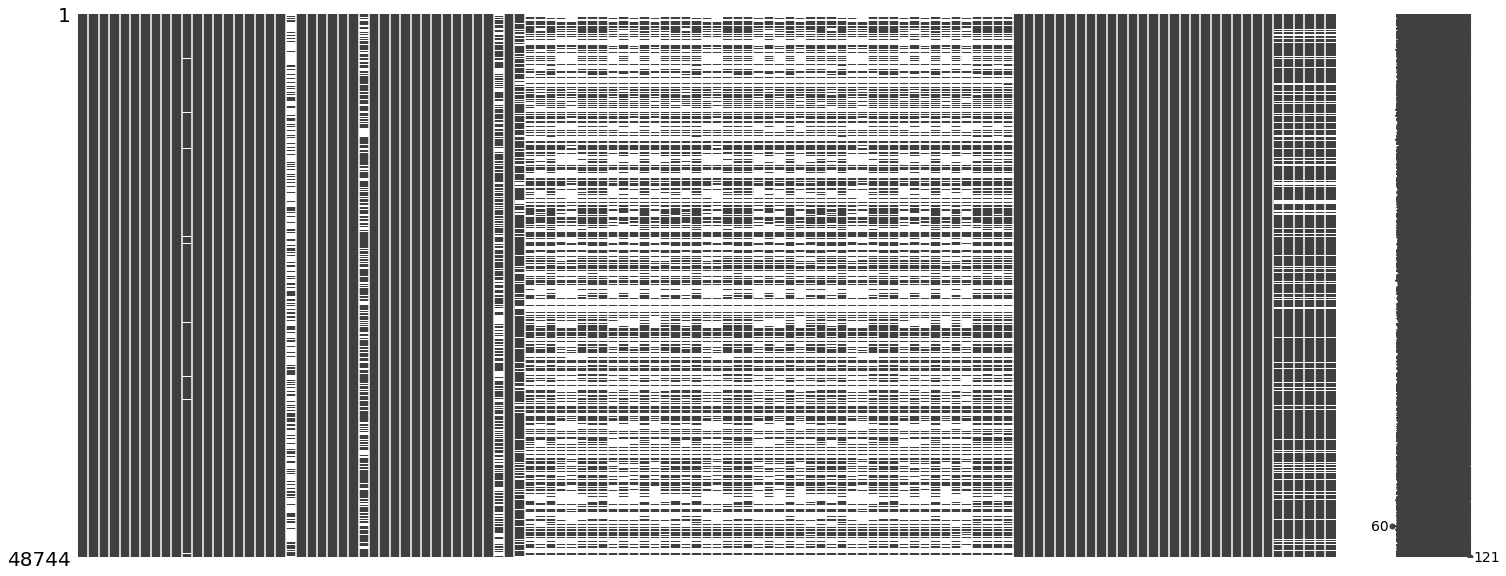

In [20]:
description_dataset(application_test, matrix= True)

## bureau_

Types :SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object
------------------------------------------------------------
         SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0

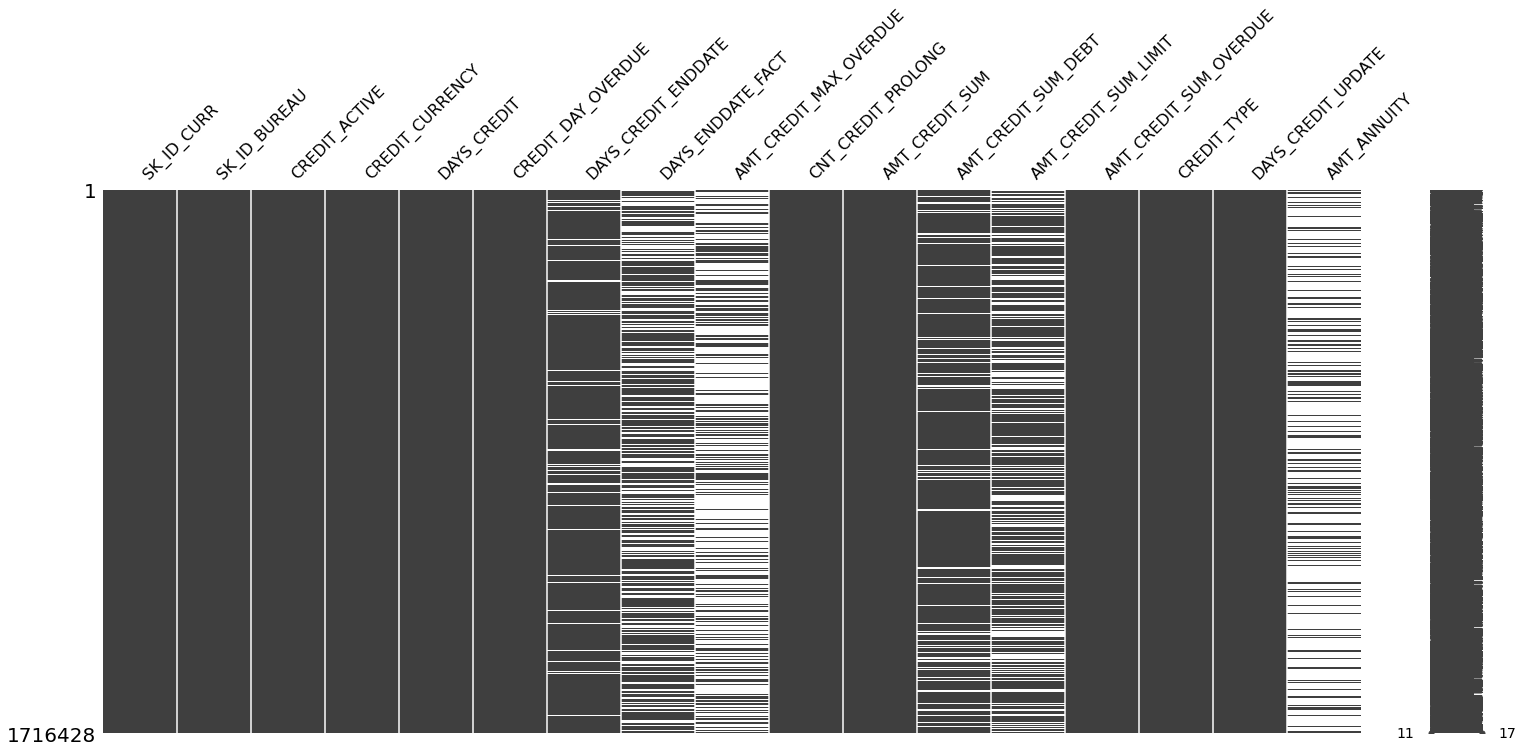

In [21]:
description_dataset(bureau_, matrix= True)

## bureau_balance

Types :SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object
------------------------------------------------------------
       SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00
------------------------------------------------------------
Valeurs manquantes par colonnes ( % ): 
SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64


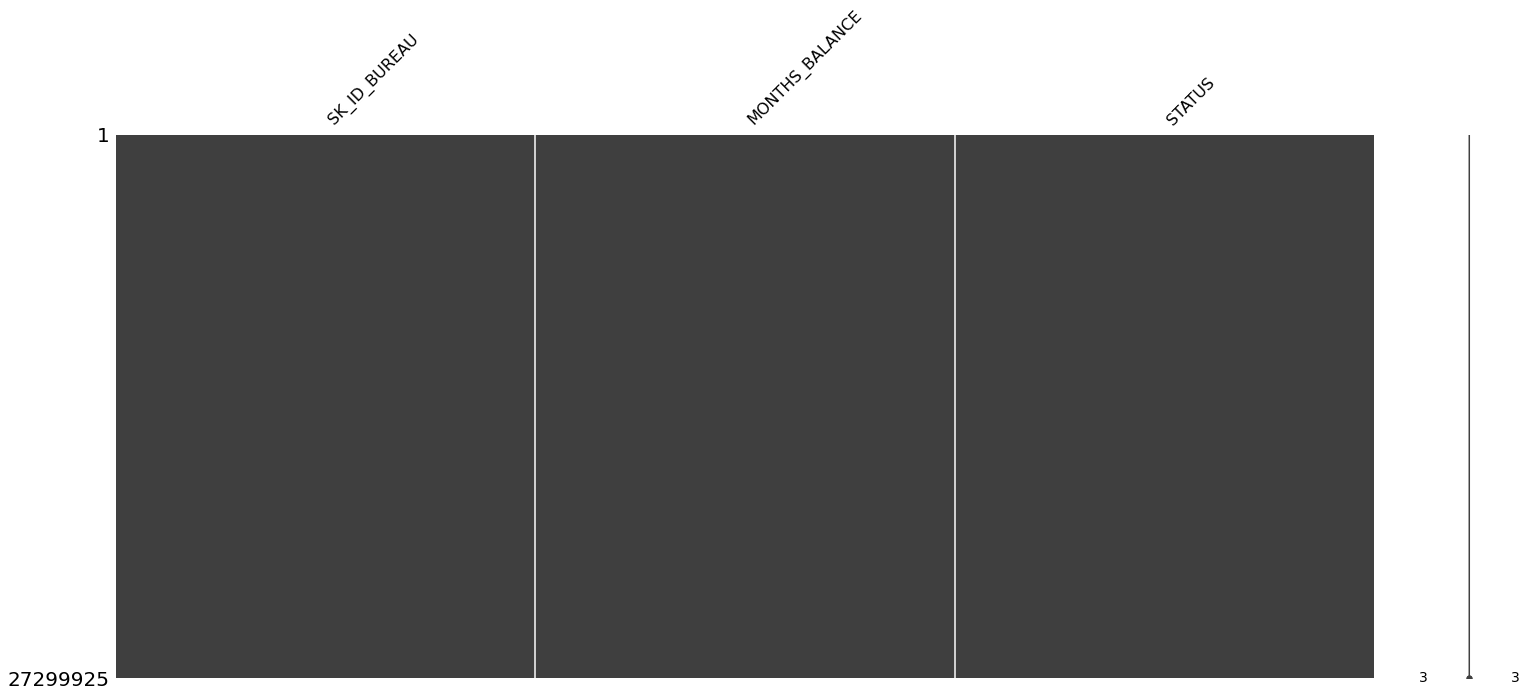

In [22]:
description_dataset(bureau_balance, matrix= True)

## credit_card_balance

Types :SK_ID_PREV                    category
SK_ID_CURR                    category
MONTHS_BALANCE                category
AMT_BALANCE                   category
AMT_CREDIT_LIMIT_ACTUAL       category
AMT_DRAWINGS_ATM_CURRENT      category
AMT_DRAWINGS_CURRENT          category
AMT_DRAWINGS_OTHER_CURRENT    category
AMT_DRAWINGS_POS_CURRENT      category
AMT_INST_MIN_REGULARITY       category
AMT_PAYMENT_CURRENT           category
AMT_PAYMENT_TOTAL_CURRENT     category
AMT_RECEIVABLE_PRINCIPAL      category
AMT_RECIVABLE                 category
AMT_TOTAL_RECEIVABLE          category
CNT_DRAWINGS_ATM_CURRENT      category
CNT_DRAWINGS_CURRENT          category
CNT_DRAWINGS_OTHER_CURRENT    category
CNT_DRAWINGS_POS_CURRENT      category
CNT_INSTALMENT_MATURE_CUM     category
NAME_CONTRACT_STATUS          category
SK_DPD                        category
SK_DPD_DEF                    category
dtype: object
------------------------------------------------------------
       SK_ID_PREV SK_

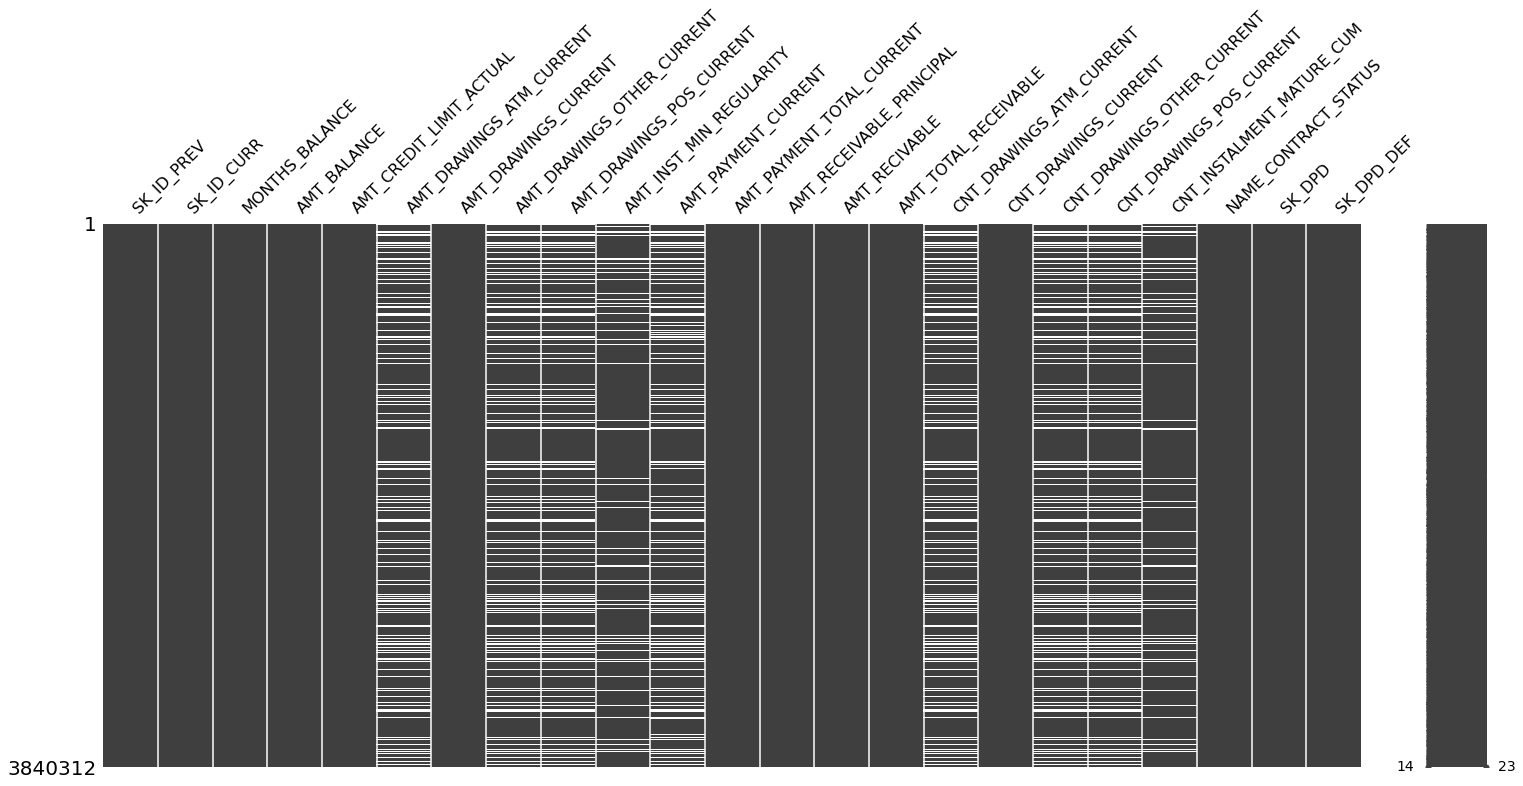

In [27]:
description_dataset(credit_card_balance2, matrix= True)

## previous_application

Types :SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE      

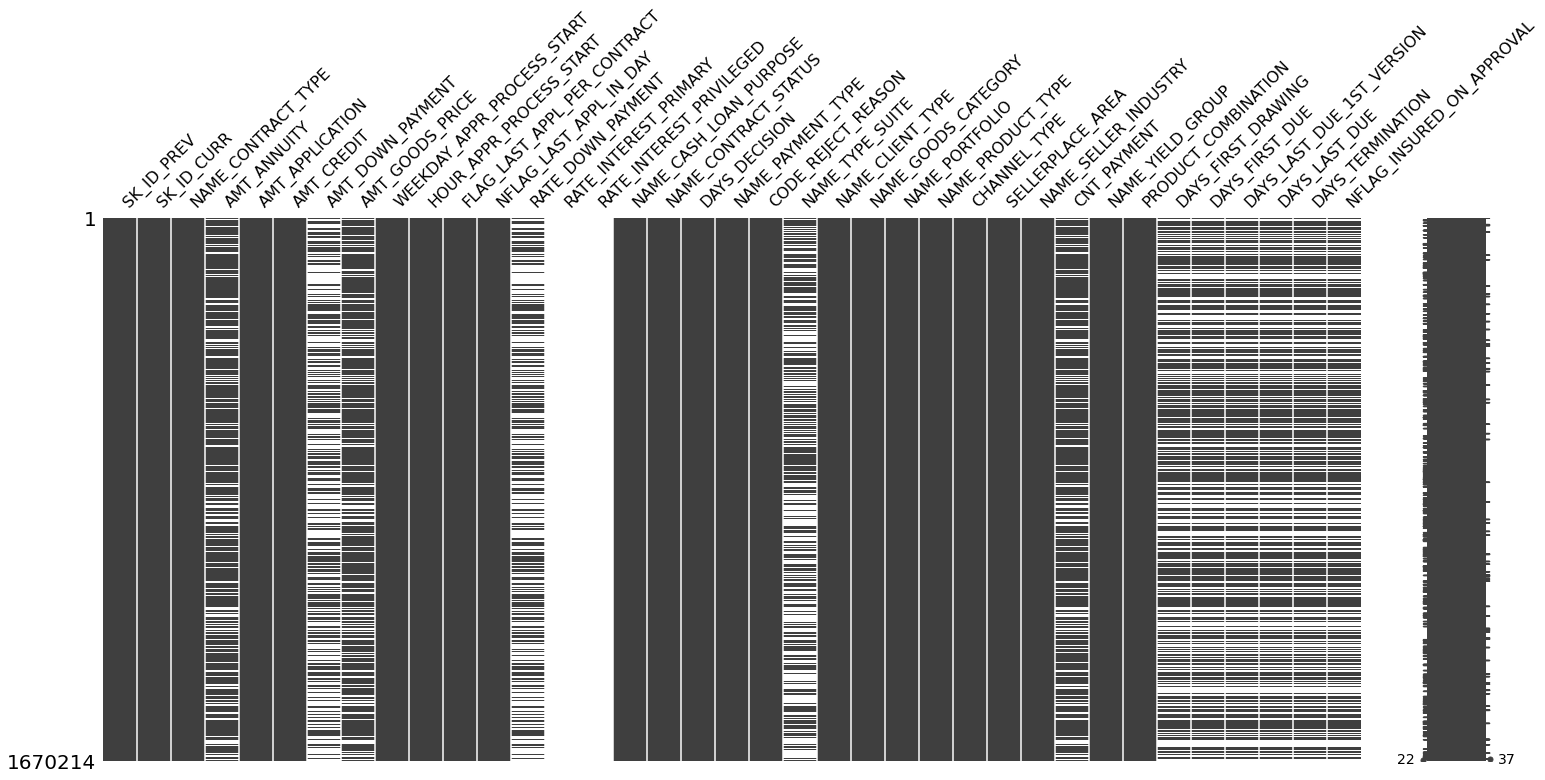

In [28]:
description_dataset(previous_application, matrix= True)

# Preprocessing des données

In [8]:
df = application_train_test(application_train)

Train samples: 307511, test samples: 48744


In [15]:
import string
translator = str.maketrans('', '', string.punctuation.replace('_', ''))
df.columns = [col.translate(translator) for col in df.columns]

In [16]:
df.shape

(356251, 248)

In [12]:
pd.set_option('display.max_columns', None)

In [15]:
print(df.isnull())

        index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       False       False   False        False         False            False   
1       False       False   False        False         False            False   
2       False       False   False        False         False            False   
3       False       False   False        False         False            False   
4       False       False   False        False         False            False   
...       ...         ...     ...          ...           ...              ...   
356250  False       False    True        False         False            False   
356251  False       False    True        False         False            False   
356252  False       False    True        False         False            False   
356253  False       False    True        False         False            False   
356254  False       False    True        False         False            False   

        CNT_CHILDREN  AMT_I

In [17]:
##### Removing the outliers
def removeOutliers(i, col):
    Q3 = np.nanquantile(i[col], 0.75)
    Q1 = np.nanquantile(i[col], 0.25)
    IQR = Q3 - Q1
     
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
    
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    
    outlier_free_list = [x for x in i[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = i.loc[i[col].isin(outlier_free_list)]
    
for p in df.columns:
    removeOutliers(df, p)
    
# Assigning filtered data back to our original variable
data_normal_energy = filtered_data
print("Shape of data after outlier removal is: ", data_normal_energy.shape)

IQR value for column index is: 173915.5
IQR value for column SK_ID_CURR is: 178127.0
IQR value for column TARGET is: 0.0
IQR value for column CODE_GENDER is: 1.0
IQR value for column FLAG_OWN_CAR is: 1.0
IQR value for column FLAG_OWN_REALTY is: 1.0
IQR value for column CNT_CHILDREN is: 1.0
IQR value for column AMT_INCOME_TOTAL is: 90000.0
IQR value for column AMT_CREDIT is: 527557.5
IQR value for column AMT_ANNUITY is: 18229.5
IQR value for column AMT_GOODS_PRICE is: 441000.0
IQR value for column REGION_POPULATION_RELATIVE is: 0.018657
IQR value for column DAYS_BIRTH is: 7251.0
IQR value for column DAYS_EMPLOYED is: 2420.0
IQR value for column DAYS_REGISTRATION is: 5482.0
IQR value for column DAYS_ID_PUBLISH is: 2601.0
IQR value for column OWN_CAR_AGE is: 10.0
IQR value for column FLAG_MOBIL is: 0.0
IQR value for column FLAG_EMP_PHONE is: 0.0
IQR value for column FLAG_WORK_PHONE is: 0.0
IQR value for column FLAG_CONT_MOBILE is: 0.0
IQR value for column FLAG_PHONE is: 1.0
IQR value for 

In [18]:
for i in df.columns :
    df[i].fillna(df[i].mode()[0], inplace=True)

In [45]:
df.describe()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning

In [29]:
from sklearn.model_selection import train_test_split

# Retirer les colonnes 'TARGET' et 'SK_ID_CURR'
X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)

# Extraire la variable cible dans une variable séparée
y = df['TARGET']

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (285000, 246)
X_test shape: (71251, 246)


In [24]:
X = df[[f for f in df.columns if f not in ['TARGET','SK_ID_CURR']]]
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (285000, 246)
X_test shape: (71251, 246)


In [27]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

columns = X_train.columns

# Remplacement des valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train, columns=columns)
X_test = imputer.transform(X_test, columns=columns)

# Sélection des colonnes catégorielles
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Centrage et réduction des variables numériques
scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [112]:
from mlflow.models.signature import infer_signature

In [114]:
import mlflow.sklearn

In [46]:
def get_scores(y_test, pred, proba, t0=0, t1=0):
    return [accuracy_score(y_test, pred),
            precision_score(y_test, pred),
            recall_score(y_test, pred),
            f1_score(y_test, pred),
            fbeta_score(y_test, pred, beta=2),
            roc_auc_score(y_test, proba),
            t1 - t0]


In [47]:
def compare_models(X_train, X_test, y_train, y_test, df, suffix, class_weights=None):

    models = {'XGB': XGBClassifier(use_label_encoder=False, random_state=42),
              'LGBM': LGBMClassifier(class_weight=class_weights, random_state=42),
              'RF': RandomForestClassifier(class_weight=class_weights, random_state=42),
              'LR': LogisticRegression(class_weight=class_weights, max_iter=1000, random_state=42)}

    weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
    if class_weights == None:
        weights = None

    for name, model in models.items():
        t0 = time.time()
        model.fit(X_train, y_train, sample_weight=weights)
        pred = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]
        t1 = time.time()
        df[name + '_' + suffix] = get_scores(y_test, pred, proba, t0, t1)

    return round(df, 3)


In [48]:
dftesttest = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc', 'time'])
compare_models(X_train, X_test, y_train, y_test, dftesttest, 'test', class_weights='balanced')

C:\Users\ruiz-\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,XGB_test,LGBM_test,RF_test,LR_test
accuracy,0.749,0.198,0.930,0.070
precision,0.165,0.079,0.561,0.070
recall,0.640,0.981,0.005,1.000
f1,0.262,0.146,0.009,0.130
f2,0.406,0.298,0.006,0.272
roc_auc,0.770,0.766,0.700,0.527
time,29.237,3.153,214.887,33.148


# Test avec undersampling

In [51]:
sample = RandomUnderSampler(random_state=10)
X_under, y_under = sample.fit_resample(X_train, y_train)

In [50]:
under = compare_models(X_under, X_test, y_under, y_test, dftesttest, 'rdm_under')
under

C:\Users\ruiz-\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,XGB_test,LGBM_test,RF_test,LR_test,XGB_rdm_under,LGBM_rdm_under,RF_rdm_under,LR_rdm_under
accuracy,0.749,0.198,0.930,0.070,0.698,0.702,0.704,0.620
precision,0.165,0.079,0.561,0.070,0.147,0.150,0.144,0.100
recall,0.640,0.981,0.005,1.000,0.694,0.702,0.657,0.558
f1,0.262,0.146,0.009,0.130,0.243,0.247,0.236,0.170
f2,0.406,0.298,0.006,0.272,0.398,0.404,0.384,0.292
roc_auc,0.770,0.766,0.700,0.527,0.764,0.773,0.746,0.628
time,29.237,3.153,214.887,33.148,4.051,0.573,13.303,6.868


# Test avec oversampling 50%

In [52]:
sample = SMOTE(sampling_strategy=0.5, random_state=42)
X_over, y_over = sample.fit_resample(X_train, y_train)

In [53]:
over = compare_models(X_over, X_test, y_over, y_test, dftesttest, 'over')
over

C:\Users\ruiz-\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,XGB_test,LGBM_test,RF_test,LR_test,XGB_rdm_under,LGBM_rdm_under,RF_rdm_under,LR_rdm_under,XGB_over,LGBM_over,RF_over,LR_over
accuracy,0.749,0.198,0.930,0.070,0.698,0.702,0.704,0.620,0.931,0.931,0.930,0.901
precision,0.165,0.079,0.561,0.070,0.147,0.150,0.144,0.100,0.523,0.611,1.000,0.155
recall,0.640,0.981,0.005,1.000,0.694,0.702,0.657,0.558,0.034,0.013,0.001,0.094
f1,0.262,0.146,0.009,0.130,0.243,0.247,0.236,0.170,0.064,0.026,0.002,0.117
f2,0.406,0.298,0.006,0.272,0.398,0.404,0.384,0.292,0.042,0.017,0.001,0.102
roc_auc,0.770,0.766,0.700,0.527,0.764,0.773,0.746,0.628,0.774,0.776,0.704,0.643
time,29.237,3.153,214.887,33.148,4.051,0.573,13.303,6.868,48.137,6.649,159.214,52.763


In [56]:
dftesttest.T.sort_values(by='roc_auc', ascending=False).head(5)

,accuracy,precision,recall,f1,f2,roc_auc,time
LGBM_over,0.930654,0.611111,0.013293,0.026020,0.016526,0.776100,6.648620
XGB_over,0.930527,0.523364,0.033837,0.063564,0.041623,0.774056,48.136685
LGBM_rdm_under,0.701997,0.150000,0.702115,0.247190,0.404408,0.772762,0.572802
XGB_test,0.749379,0.165073,0.639879,0.262443,0.406204,0.769992,29.236508
LGBM_test,0.198369,0.078713,0.981269,0.145735,0.297960,0.765799,3.153497


In [57]:
import time
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             fbeta_score, roc_auc_score)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV


def get_scores(y_test, pred, proba, t0=0, t1=0):
    return [accuracy_score(y_test, pred),
            precision_score(y_test, pred),
            recall_score(y_test, pred),
            f1_score(y_test, pred),
            fbeta_score(y_test, pred, beta=2),
            roc_auc_score(y_test, proba),
            t1 - t0]


def compare_models(X_train, X_test, y_train, y_test, df, suffix, class_weights=None):

    if class_weights is None:
        weights = None
    else:
        weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
        
    models = {
        "XGB": XGBClassifier(use_label_encoder=False, random_state=42),
        "LGBM": LGBMClassifier(class_weight=class_weights, random_state=42),
        "RF": RandomForestClassifier(class_weight=class_weights, random_state=42),
        "LR": LogisticRegression(class_weight=class_weights, max_iter=1000, random_state=42)
    }
    
    for name, model in models.items():
        if name == "XGB":
            params = {"learning_rate": [0.01, 0.1, 0.5],
                      "n_estimators": [100, 200, 500]}
        elif name == "LGBM":
            params = {"learning_rate": [0.01, 0.1, 0.5],
                      "n_estimators": [100, 200, 500],
                      "max_depth": [3, 5, 7]}
        elif name == "RF":
            params = {"n_estimators": [100, 200, 500],
                      "max_depth": [3, 5, 7]}
        else:
            params = {"C": [0.01, 0.1, 1, 10]}

        grid = GridSearchCV(model, param_grid=params, scoring="roc_auc", cv=5, n_jobs=-1)
        t0 = time.time()
        grid.fit(X_train, y_train, sample_weight=weights)
        pred = grid.predict(X_test)
        proba = grid.predict_proba(X_test)[:, 1]
        t1 = time.time()
        df[name + '_' + suffix] = get_scores(y_test, pred, proba, t0, t1)

    return round(df, 3)


Ici, nous avons ajouté un bloc de code pour définir les paramètres pour chaque modèle, puis créé une instance de GridSearchCV pour chaque modèle en utilisant ces paramètres. Nous utilisons le score ROC AUC pour l'optimisation des hyperparamètres, qui est une mesure courante de la performance des modèles de classification. Nous avons également utilisé une validation croisée à 5 plis pour évaluer les performances des modèles. Enfin, nous avons remplacé l'ajustement du modèle et la prédiction des prévisions par la méthode GridSearchCV pour permettre la recherche des meilleurs

In [55]:
compare_models(X_over, X_test, y_over, y_test, results, 'SMOTE')

`use_label_encoder` is deprecated in 1.7.0.


,XGB_SMOTE,LGBM_SMOTE,RF_SMOTE,LR_SMOTE,hyperopt_roc
accuracy,0.930,0.930,0.930,0.901,0.723
precision,0.447,0.507,0.583,0.155,0.157
recall,0.033,0.014,0.001,0.094,0.682
f1,0.062,0.028,0.003,0.117,0.256
f2,0.041,0.018,0.002,0.102,0.409
roc_auc,0.768,0.770,0.696,0.643,0.779
time,66.949,5.948,268.091,72.898,15.605


In [50]:
results = compare_models(X_over, X_test, y_over, y_test, results, 'SMOTE')
results

C:\Users\ruiz-\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
2023/02/23 13:10:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5776c352107a47e8bfbaef89c61093fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/02/23 13:16:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ruiz-\anaconda3\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) t

,XGB_SMOTE,LGBM_SMOTE,RF_SMOTE,LR_SMOTE
accuracy,0.930,0.930,0.930,0.901
precision,0.447,0.507,0.583,0.155
recall,0.033,0.014,0.001,0.094
f1,0.062,0.028,0.003,0.117
f2,0.041,0.018,0.002,0.102
roc_auc,0.768,0.770,0.696,0.643
time,67.290,5.954,373.459,78.641


# Install MLflow

In [59]:
pip install mlflow

  Created wheel for databricks-cli: filename=databricks_cli-0.17.4-py3-none-any.whl size=142889 sha256=889a15b5f71b7b83b2d430a9080b89f4becb130a4d14db9de0d9c04e9da59cd4
  Stored in directory: c:\users\ruiz-\appdata\local\pip\cache\wheels\b3\d4\24\ed7f421c3c600f3eee1a3a9e5c4aecc286a7622cac031918b7
Successfully built databricks-cli
  Attempting uninstall: pywin32
    Found existing installation: pywin32 302
    Uninstalling pywin32-302:
      Successfully uninstalled pywin32-302
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.


# Courbe Roc

In [58]:
# Définition des hyperparamètres du modèle
model = LGBMClassifier(class_weight='balanced', random_state=42)

# Entraînement du modèle sur les données d'entraînement
features_train = X_train  # X_train représente les caractéristiques d'entraînement
labels_train = y_train   # y_train représente les étiquettes d'entraînement
model.fit(features_train, labels_train)

# Prédiction des scores de probabilité pour les données de test
features_test = X_test   # X_test représente les caractéristiques de test
predicted_probabilities = model.predict_proba(features_test)[:, 1]
score = predicted_probabilities


In [59]:
# Importation des bibliothèques nécessaires
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Définition de la fonction plot_roc_curve
def plot_roc_curve(X_test, y_test, score):
    # Calcul des taux de faux positifs, de vrais positifs et des seuils
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, score)

    # Tracé de la courbe ROC
    plt.plot(false_positive_rate, true_positive_rate, marker='.', label='LR')

    # Ajout des étiquettes des axes et de la légende
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend()

    # Affichage de la courbe ROC
    plt.show()

    # Calcul et affichage de l'aire sous la courbe ROC (ROC AUC score)
    roc_auc = roc_auc_score(y_test, score)
    print('roc_auc_score: %.3f' % roc_auc)


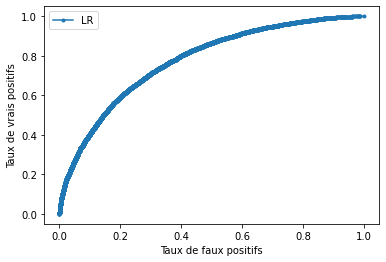

roc_auc_score: 0.776


In [60]:
plot_roc_curve(X_test, y_test, score)

In [ ]:
# Définition des hyperparamètres du modèle
modellog = LogisticRegression(class_weight='balanced', random_state=42)

# Entraînement du modèle sur les données d'entraînement
features_trainlog = X_train  # X_train représente les caractéristiques d'entraînement
labels_trainlog = y_train   # y_train représente les étiquettes d'entraînement
modellog.fit(features_trainlog, labels_trainlog)

# Prédiction des scores de probabilité pour les données de test
features_testlog = X_test   # X_test représente les caractéristiques de test
predicted_probabilitieslog = model.predict_proba(features_testlog)[:, 1]
scorelog = predicted_probabilities


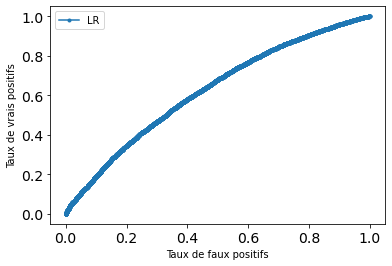

roc_auc_score: 0.625


In [163]:
plot_roc_curve(X_test, y_test, score)

# Optimisation du modèle LGBMClassifier avec GridSearchCV

In [62]:
param_grid = {
                'num_leaves': [31, 127],
                'reg_alpha': [0.1, 0.5],
                'min_data_in_leaf': [30, 50, 100, 300, 400],
                'lambda_l1': [0, 1, 1.5],
                'lambda_l2': [0, 1]
           }

In [61]:
import lightgbm as lgb

In [63]:
grid = GridSearchCV(lgb.LGBMClassifier(
    class_weight='balanced', random_state=42), param_grid, scoring="roc_auc", cv=5)

In [64]:
grid.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [31, 127], 'reg_alpha': [0.1, 0.5]},
             scoring='roc_auc')

In [65]:
print(grid.best_score_)
print(grid.best_params_)

0.7788156085204108
{'lambda_l1': 1, 'lambda_l2': 1, 'min_data_in_leaf': 400, 'num_leaves': 31, 'reg_alpha': 0.1}


In [68]:
modelupdate = grid.best_estimator_
modelupdate

LGBMClassifier(class_weight='balanced', lambda_l1=1, lambda_l2=1,
               min_data_in_leaf=400, random_state=42, reg_alpha=0.1)

# mATRICE DE CONFUSION

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [72]:
print(classification_report(y_test, modelupdate.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     66286
         1.0       0.16      0.68      0.25      4965

    accuracy                           0.72     71251
   macro avg       0.56      0.70      0.54     71251
weighted avg       0.91      0.72      0.79     71251



In [70]:
confusion_matrix(y_test, modelupdate.predict(X_test))

array([[47896, 18390],
       [ 1565,  3400]], dtype=int64)

# feature_importance

In [58]:
feature_importance_values = model.feature_importances_

feats = pd.DataFrame({'feature': list(X_train.columns),
                      'importance': feature_importance_values})

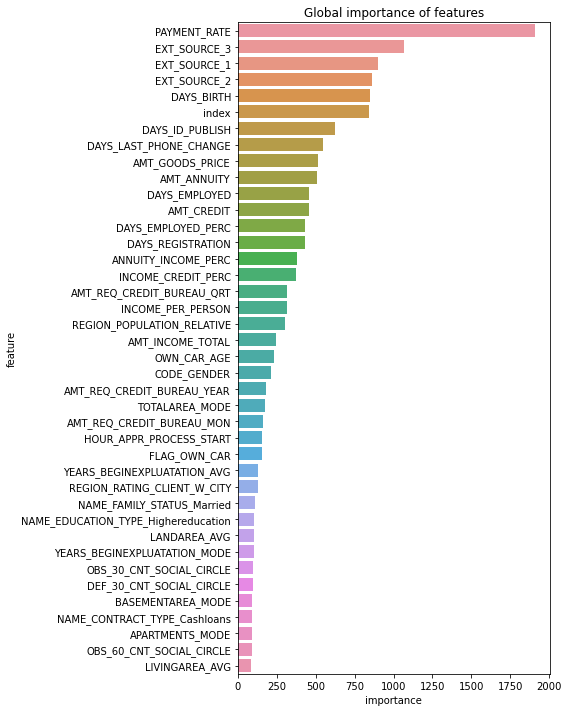

In [53]:
def display_importances(feats, nb_feats):
    feats = feats.groupby("feature").mean().reset_index()
    best_feats = feats.nlargest(nb_feats, "importance")
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_feats)
    plt.title('Global importance of features')
    plt.tight_layout()
    
display_importances(feats, 40)

# Enregistrement du modèle pour FastAPI (première partie)

In [75]:
from sklearn.pipeline import Pipeline

In [76]:
pipe_pred = Pipeline([('clf', lgb.LGBMClassifier(**grid.best_params_))])
pipe_pred.fit(X_train, y_train)
pipe_pred.score(X_train,y_train)
pipe_pred.score(X_test,y_test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


0.9308641282227618

In [78]:
import pickle

In [79]:
# save the model to disk
filename = 'API_LGBMClassifier.pkl'
pickle.dump(pipe_pred, open(filename, 'wb'))

In [80]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9308641282227618


# optimisation avec hyperopt

In [82]:
# optimisation du modèle
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

In [36]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [83]:
space={'n_estimators': scope.int(hp.quniform('n_estimators', 200, 2000, 200)),
       'max_depth' : scope.int(hp.quniform('max_depth', 2, 30, 2)),
       'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
       'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
       'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
       'num_leaves': scope.int(hp.quniform('num_leaves', 4, 100, 4)),
       'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
       'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1)
}

In [84]:
def hyperparameter_tuning(params):
    clf = LGBMClassifier(**params, class_weight='balanced', n_jobs=-1, random_state=42)
    score = cross_val_score(clf, X_train, y_train ,scoring="f1_weighted", error_score='raise').mean()
    return {"loss": -score, "status": STATUS_OK}

In [85]:
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space = space, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials
            )

print("Best: {}".format(best))

100%|██████████| 10/10 [13:33<00:00, 81.35s/trial, best loss: -0.9027965999049288]
Best: {'colsample_by_tree': 0.7000000000000001, 'learning_rate': 0.1435166588670314, 'max_depth': 14.0, 'n_estimators': 1600.0, 'num_leaves': 88.0, 'reg_alpha': 0.9, 'reg_lambda': 0.4, 'subsample': 0.8}


In [86]:
# best params roc_auc
modelhyper = LGBMClassifier(n_estimators= 1000,
       max_depth= 10,
       learning_rate=0.02,
       subsample=0.2,
       colsample_bytree=0.7,
       num_leaves=20,
       reg_alpha=0.4,
       reg_lambda=0.2,
       class_weight='balanced')

In [87]:
t0 = time.time()
modelhyper.fit(X_train, y_train)
pred = modelhyper.predict(X_test)
proba = modelhyper.predict_proba(X_test)[:, 1]
t1 = time.time()
results['hyperopt_roc'] = get_scores(y_test, pred, proba, t0, t1)
round(results,3)

,hyperopt_roc
accuracy,0.723
precision,0.157
recall,0.682
f1,0.256
f2,0.409
roc_auc,0.779
time,10.379


In [88]:
over

,XGB_test,LGBM_test,RF_test,LR_test,XGB_rdm_under,LGBM_rdm_under,RF_rdm_under,LR_rdm_under,XGB_over,LGBM_over,RF_over,LR_over
accuracy,0.749,0.198,0.930,0.070,0.698,0.702,0.704,0.620,0.931,0.931,0.930,0.901
precision,0.165,0.079,0.561,0.070,0.147,0.150,0.144,0.100,0.523,0.611,1.000,0.155
recall,0.640,0.981,0.005,1.000,0.694,0.702,0.657,0.558,0.034,0.013,0.001,0.094
f1,0.262,0.146,0.009,0.130,0.243,0.247,0.236,0.170,0.064,0.026,0.002,0.117
f2,0.406,0.298,0.006,0.272,0.398,0.404,0.384,0.292,0.042,0.017,0.001,0.102
roc_auc,0.770,0.766,0.700,0.527,0.764,0.773,0.746,0.628,0.774,0.776,0.704,0.643
time,29.237,3.153,214.887,33.148,4.051,0.573,13.303,6.868,48.137,6.649,159.214,52.763


# Shap

In [89]:
import shap
from sklearn.neighbors import NearestNeighbors

In [90]:
modelshap=LGBMClassifier() # initialize the model
modelshap.fit(X_train,y_train) # fit he modelX_test_feat_selection
y_pred=modelshap.predict(X_test) # now predict

In [92]:
# Fits the explainer
explainerLGBM = shap.Explainer(modelshap.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_valuesLGBM = explainerLGBM(X_test)

Permutation explainer: 71252it [1:08:58, 17.18it/s]                           


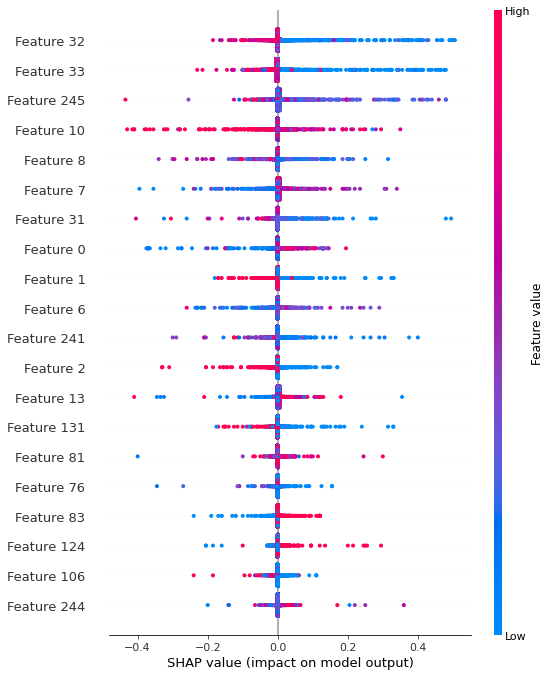

In [93]:
shap.summary_plot(shap_valuesLGBM)

In [61]:
from sklearn.linear_model import LinearRegression

lireg=LinearRegression() # initialize the model
lireg.fit(X_train,y_train) # fit he modelX_test_feat_selection
y_pred=lireg.predict(X_test) # now predict

2023/02/23 13:36:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1f412270f8304377b342caccace6bdf5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/02/23 13:36:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ruiz-\anaconda3\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values 

In [91]:

from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [ ]:
# Fits the explainer
explainer = shap.Explainer(lireg.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 71252it [1:13:34, 16.11it/s]                           


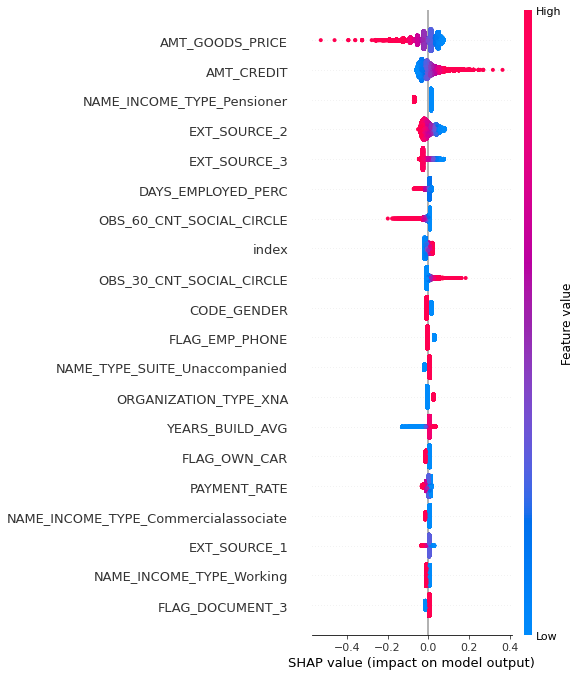

In [174]:
shap.summary_plot(shap_values)

# Enregistrement du modèle pour FastAPI

In [100]:
%%time
LGBMC = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_by_tree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    class_weight= 'balanced',
    num_leaves= int(best['num_leaves']),
    reg_alpha= best['reg_alpha'],
    reg_lambda= best['reg_lambda'])

LGBMC.fit(X_train, y_train)
                                 # le modèle retenu pour la prédiction
pickle.dump(LGBMC, open("C:\\Users\\ruiz-\\OneDrive\\Bureau\\Projet6\\API_LGBMClassifier.pkl",
                      "wb"))   

CPU times: total: 5min 19s
Wall time: 21.8 s


In [102]:
roc_auc_sc = roc_auc_score(y_test, LGBMC.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc_sc)

AUC : 0.733883


# Brouillon test

In [ ]:
from sklearn.pipeline import make_pipeline

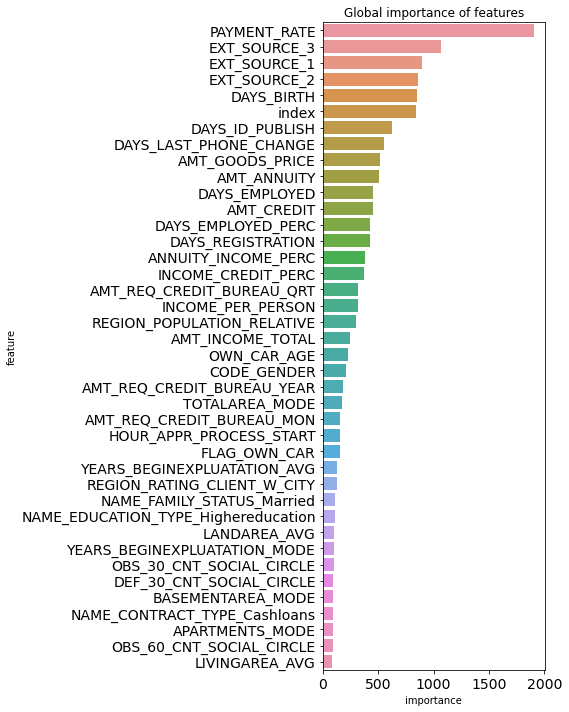

In [154]:
def display_importances(feats, nb_feats):
    feats = feats.groupby("feature").mean().reset_index()
    best_feats = feats.nlargest(nb_feats, "importance")
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_feats)
    plt.title('Global importance of features')
    plt.tight_layout()
    
display_importances(feats, 40)

In [65]:
# On crée une pipeline reprenant les différents éléments nous ayant permis d'obtenir le meilleur f3-score précédemment.

pipeline_lreg = make_pipeline(SimpleImputer(strategy='median'),LogisticRegression(class_weight='balanced', C=5.623413251903491e-05,
                                               solver='liblinear', penalty='l2'))

In [66]:
# On l'entraîne sur l'ensemble du dataset d'entraînement sur lequel nous avons obtenu le meilleur f3-score également.

pipeline_lreg.fit(X_train, y_train)

2023/02/23 16:38:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ae65d82d901f483d8fde16e67676e8dc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
Liblinear failed to converge, increase the number of iterations.
2023/02/23 16:39:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ruiz-\anaconda3\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('logisticregression',
                 LogisticRegression(C=5.623413251903491e-05,
                                    class_weight='balanced',
                                    solver='liblinear'))])

In [67]:
pipeline_lreg.score(X_test, y_test)

0.6177878205218172

In [108]:
pipeline.score(X_test, y_test)

0.9307658839875932

In [68]:
joblib.dump(pipeline_lreg, 'pipeline_credit.joblib')

['pipeline_credit.joblib']

In [186]:
y_pred = pipeline_lreg.predict(X_test)

In [111]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.62      0.75     66286
         1.0       0.10      0.58      0.17      4965

    accuracy                           0.62     71251
   macro avg       0.53      0.60      0.46     71251
weighted avg       0.89      0.62      0.71     71251



In [188]:
confusion_matrix(y_test, y_pred)

array([[41134, 25152],
       [ 2081,  2884]], dtype=int64)

In [113]:
signature = infer_signature(X_train, y_train)

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [119]:
mlflow.sklearn.save_model(pipeline_lreg, 'mlflow_modelcredit2', signature=signature)

In [ ]:
mlflow models serve -m mlflow_modelcredit2/

In [143]:
mlflow.autolog()

2023/02/17 11:07:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/02/17 11:07:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/02/17 11:07:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/02/17 11:07:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/02/17 11:07:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/02/17 11:07:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [146]:
mlflow.artifacts.


<module 'mlflow.artifacts' from 'C:\\Users\\ruiz-\\anaconda3\\lib\\site-packages\\mlflow\\artifacts\\__init__.py'>

In [68]:
pipeline = pipeline.Pipeline([('regressor', LGBMClassifier())])

In [69]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('regressor', LGBMClassifier())])

In [70]:
pipeline.score(X_test, y_test)

0.9307658839875932

In [71]:
joblib.dump(pipeline, 'pipeline_CREDIT.joblib')

['pipeline_CREDIT.joblib']

In [63]:
joblib.dump(explainer, 'explainer.joblib')

['explainer.joblib']

In [106]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [107]:
application_test.columns.all

<bound method Index.all of Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)>

In [115]:
application_test

KeyboardInterrupt: 

In [124]:
col_model = ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
'CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE',
'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','FLAG_MOBIL',
             'FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','CNT_FAM_MEMBERS',
             'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION',
             'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
             'ORGANIZATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
             'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG',
             'NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
             'FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI',
             'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI',
             'LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE','TOTALAREA_MODE',
             'WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
             'DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8',
             'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
             'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
             'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']


In [129]:
col_model.count

<function list.count(value, /)>

# Evidently et data drift

In [130]:
pip install evidently


  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [135]:
import pandas as pd
import numpy as np
import evidently
from evidently.dashboard import Dashboard
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from evidently.tabs import DataDriftTab

# Charger les données
datatraindrift = pd.read_csv('application_train.csv')
datatestdrift = pd.read_csv('application_test.csv')

In [140]:
pip install --upgrade evidently

In [146]:
from evidently.tabs import DriftTab

ImportError: cannot import name 'DriftTab' from 'evidently.tabs' (C:\Users\ruiz-\anaconda3\lib\site-packages\evidently\tabs\__init__.py)

In [147]:
# Séparer les données en ensembles de référence et de comparaison
ref_data = datatraindrift[:1000]
cmp_data = datatraindrift[1000:]

# Instancier la classe DriftTab
drift_tab = DataDriftTab(ref_data, cmp_data, column_mapping=None, analyzer_class=None)

# Instancier la classe Dashboard et ajouter la tab DriftTab
dashboard = Dashboard(tabs=[drift_tab])

# Générer le rapport
dashboard.save("drift_report.html")

TypeError: __init__() got an unexpected keyword argument 'column_mapping'

Elle permet d'analyser divers aspects de la performance des modèles tels que la précision, la stabilité, l'équité, la robustesse, etc. L'analyse de la qualité du modèle est essentielle pour comprendre la façon dont le modèle fonctionne et pour s'assurer qu'il fonctionne correctement.

L'analyse de data drift, également appelée dérive de données, est une méthode pour évaluer les changements dans les données d'entraînement et de test au fil du temps. Elle permet de détecter les écarts entre les données d'entraînement et de test et d'évaluer leur impact sur la performance du modèle. En général, une dérive de données peut survenir pour diverses raisons, telles que des changements dans la distribution des données, des erreurs de saisie, des changements dans le comportement des utilisateurs, etc. En conséquence, il est essentiel d'effectuer une analyse de dérive de données pour s'assurer que le modèle est toujours précis et fiable, même si les données évoluent au fil du temps.